# Classifying Image Crops
In this module, we load pre-made image crops of fibers and void spaces, and classify them with the already trained model "model-isvc.h5". Note that the first section of this notebook is a reproduction of the experiments outlined in *"Evaluating Fiber Detection Models using Neural Networks".*

This time, you won't get the chance to regenerate the model, since we have already done that in our paper. Instead you will get to see the results we obtained.

However, below the reproduction of our results, we give you the opportunity to generate your own image crops, retrain a model and classify them accordingly.

First, we will introduce all our auxiliary functions needed for this notebook.

## Auxiliary Functions
All functions needed to reproduce experiments, as well as create your own set of images below the reproducibility section.

In [1]:
# Function to sort files
def sort_files(list_files):
    """
    Sorts file list (image slices)
    to preserve order.
    
    list_files: list of files from
    os.listdir
    returns: list of files.
    """
    sort_list = sorted(map(int,list_files))
    to_str = list(map(str,sort_list))

    return to_str

In [2]:
# label creation for binary data
def create_labels(ones_size, zeros_size):
    """
    Generation of class labels accroding
    to given sizes:
    
    input1: length/number of 1's desired
    input2: length/number of 0's desired
    returns: complete list of labels accor-
    ding to the specifications on input
    """
    
    the_ones = np.ones(ones_size).tolist()
    the_zeros = np.zeros(zeros_size).tolist()
    concat_labels = the_ones + the_zeros
    
    return concat_labels

In [3]:
def make_dataframe(list_of_imgs, ones, zeros):
    """
    Creates data frame from a list of images
    and adds appropriate labels based on
    sizes (ones and zeros)
    
    input 1: list of images
    input 2: number of 1's
    input 3: number of 0's
    
    returns: dataframe with labels
    """
    frame = pd.DataFrame(list_of_imgs)
    # attach labels according to sizes (ones and zeros)
    frame['Labels'] = create_labels(ones, zeros)
    
    return frame

In [4]:
def matrix_shuffle(list_1, list_2, ones, zeros, separate_files=False):
    """
    Uses lists on input to create dataframes 
    with appropriate labels. Concatenates
    these dataframes as a way to build our X 
    and y prior to training and testing.
    Shuffles the matrix (X) to introduce random-
    ness in test/training process.
    
    input 1: list of imgs
    input 2: list of imgs (another one)
    input 3: number of 1's
    input 4: number of 0's
    
    output: shuffled matrix (no labels), labels
    """
    
    # creates dataframe with labels 
    if separate_files:
        frame_1 = make_dataframe(list_1, ones, 0)
        frame_2 = make_dataframe(list_2, 0, zeros)
    else:
        frame_1 = make_dataframe(list_1, ones, zeros)
        frame_2 = make_dataframe(list_2, ones, zeros)
    
    list_frames = [frame_1, frame_2]
    
    # double check here that the labels are kept as they should, 
    # it works!
    attach_them = pd.concat(list_frames, ignore_index=True)
    
    # shuffle it!
    attached_shuffle = attach_them.sample(frac=1).reset_index(drop=True)
    
    # drop the labels but save-them!
    y_labels = attached_shuffle['Labels']
    attached_no_labels = attached_shuffle.drop(['Labels'], axis=1)
    
    # returns shuffled matrix without labels, and its dropped labels
    return attached_no_labels, y_labels

In [5]:
def unflatten_values(unlabeled_dataframe):
    """
    Takes the unlabeled dataframe's values,
    to unflatten them to (16,16) imgs
    inside a list. Returns list.
    
    input 1: dataframe with no labels
    output: list of unflattened images
    """
    values = unlabeled_dataframe.values
    temp_unflat = []
    for element in values:
        un = element.reshape(16,16)
        temp_unflat.append(un)
        
    return temp_unflat
        

In [6]:
def conf_matrix(y, predictions):
    cm= confusion_matrix(y.argmax(axis=1), predictions.argmax(axis=1), labels=[0,1])
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    TN = cm[0,0]

    # Sensitivity, hit rate, recall, or true positive rat
    TPR = TP/(TP+FN)
        # Specificity or true negative rate
    TNR = TN/(TN+FP)
        # Precision or positive predictive value
    PPV = TP/(TP+FP)
        # Negative predictive value
    NPV = TN/(TN+FN)
        # Fall out or false positive rate
    FPR = FP/(FP+TN)
        # False negative rate
    FNR = FN/(TP+FN)
        # False discovery rate
    FDR = FP/(TP+FP)

        # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    all_results = {'Sensitivity': TPR, 'Specificity': TNR, 'Precision': PPV,
                  'Neg. Pred Rate': NPV, 'False Pos. Rate': FPR,
                  'False Neg. Rate': FNR, 'False Discovery Rate:': FDR,
                  'Accuracy': ACC}
    
    frame_results = pd.DataFrame(list(all_results.items()), columns = ['Measure', 'Rates'])
    
    #return frame_results, cm, (TP, FN, FP, TN)
    return all_results

In [7]:
def predict_natalies(fibs, voids, cnn_model, rotate = False):
    
    if rotate:
        fib_resize = [transform.rotate(transform.resize(rgb2gray(a),(16,16), anti_aliasing=True),angle=90).flatten() for a in fibs]
        void_resize = [transform.rotate(transform.resize(rgb2gray(b), (16,16), anti_aliasing=True),angle=90).flatten() for b in voids]
    else:
        fib_resize = [transform.resize(rgb2gray(a),(16,16), anti_aliasing=True).flatten() for a in fibs]
        void_resize = [transform.resize(rgb2gray(b), (16,16), anti_aliasing=True).flatten() for b in voids]
    
    shuf_imgs, shuf_labels = matrix_shuffle(fib_resize, void_resize, len(fib_resize),
                                 len(void_resize), separate_files=True)
    
    X = np.asarray(unflatten_values(shuf_imgs)).astype('float32')
    X = X.reshape(X.shape[0], 16, 16, 1)
    
    y = to_categorical(shuf_labels)
    
    # making the prediction
    pred = cnn_model.predict(X)
    pred = (pred > 0.5)
    
    # get measurements: grades is a dictionary
    results = conf_matrix(y, pred)
    
    return results

In [8]:
def metrics_dataframe(your_list):
    """
    Converts list of dictionaries to
    data frame ensuring order in list. 
    (since lists preserve order)
    
    your_list : list of dictionaries
    output: dataframe of however many
    rows (elements) in your_list.
    """
    
    size = len(your_list)
    all_mets_df = pd.DataFrame()
    
    for dic in range(size):
        temp_df = pd.DataFrame(your_list[dic], index=[0])
        all_mets_df = all_mets_df.append(temp_df, 
                                         ignore_index = True)
        
    return all_mets_df

In [9]:
def auto_crop(segmented_image, raw_image, image_number, path):
    
    """
    Crops fibers enclosed in the regions detected by regionprops.
    These crops are generated based on the segmentations done
    by someone else, found in 'segmented_image'.
    
    @segmented_image: segmented of image cross-section from specimen.
    @raw_image:     raw image x-section from microCT scanned specimen. 
                    Note that this x-section corresponds to the same
                    image slice as the segmented_image.
    @image_number:  number of image slice
    @path:          path to a directory on which the images will 
                    be saved.
    output:         image crops found in "@path + /image_number".
    """
    
    # bounds for area within image
    minRegionArea = 150
    maxRegionArea = 50000
    
    # get dimensions of segmented_image    
    w, h = segmented_image.shape
        
    # label the segmented_image
    labeled = label(segmented_image)
    
    # get region properties
    props = regionprops(labeled)
    
    # iterate throuh all properties
    for i,p in enumerate(props):  
        # coordinates of rectangle enclosing fibers
        min_y = max(0, p.bbox[0]) 
        min_x = max(0, p.bbox[1])
        max_y = max(0, p.bbox[2])
        max_x = max(0, p.bbox[3])
        
        # crop according to coords the raw microCT 
        crop = raw_image[min_y:max_y, min_x:max_x]
        
        # normalize and save as gray image
        cmap = plt.cm.gray
        normalize = plt.Normalize(vmin=crop.min(),
                                 vmax=crop.max())
        fiber_crop = cmap(normalize(crop))
        
        string_one = "_" + str(p.bbox[0]) + "_" + str(p.bbox[2])
        string_two = "_" + str(p.bbox[1]) + "_" + str(p.bbox[3])
        coords = string_one + string_two
        
        save_prefix = path + str(image_number)
        save_in = save_prefix + "/crop" + str(i) + coords +'.png'
        
        if not os.path.isdir(save_prefix):
            os.mkdir(save_prefix)
            
        plt.imsave(save_in, fiber_crop)         

In [10]:
def manual_crop(raw_image, csv, path, slice_number):
    
    """
    Crop fibers selected manually from coordinates
    in given csv file. Once cropped, each image is
    saved in path.
    
    @raw_image = microCT image slice to crop from
    @csv =       csv filename with saved coordinates 
                 from corresponding image slice.
    @path =      directory path where to save all 
                 images.
    @slice_number = image crops from slice_number
                 cross-section. 
    """
    
    # load data
    extract_file = np.genfromtxt(csv, 
                                 delimeter = ",",
                                skip_header = 1)  
    for line in extract_file:
        # unpack contents
        fiber_number, x, y = line
        
        # crop accordint to selection in line
        crop = raw_image[int(y)-12:int(y)+12,
                        int(x)-12:int(x)+12]
        
        # save as gray & normalize
        cmap = plt.cm.gray
        normalize = plt.Normalize(vmin=crop.min(),
                                 vmax=crop.max())
        fiber_crop = cmap(normalize(crop))
        
        # save file name convention
        coords = "_"+ str(x) + "_" +str(y) + ".png"
        directory = path + str(slice_number)
        save_in = directory + '/crop' + coords
        
        if not os.path.isdir(directory):
            os.mkdir(directory)
            
        plt.imsave(save_in, fiber_crop)  

In [11]:
def void_crops(segmented_image, raw_image, slice_number, path):
    
    # 217 is the value of fiber intensity in seg. ground truth
    voids = segmented_image != 217
    voids = morphology.binary_erosion(voids)
    voids = morphology.binary_erosion(voids)
    voids = morphology.binary_erosion(voids)
    
    # label eroded voids
    voids_labeled = label(voids)
    
    # limits on measurements
    largest = 10
    ws = largest
    area_largest = np.square(largest)
    
    # get properties of labeled eroded regions
    void_regions = regionprops(voids_labeled)
    count = 0
    
    for prop in void_regions:
        
        # get rectangular box for region
        w = prop.bbox[2] - prop.bbox[0]
        h = prop.bbox[3] - prop.bbox[1]
        
        # region detected must meet the following conditions
        a = prop.convex_area >= area_largest
        b = w > largest
        c = h > largest
        d = prop.eccentricity > 0.5
        
        # we will only crop if a-d are met:
        if a & b & c & d:
            # crop the voids not ground_truth 
            binary = voids[prop.bbox[0]:prop.bbox[2],
                           prop.bbox[1]:prop.bbox[3]]*prop.convex_image
            h, w = binary.shape
            
            # now find the valid rectangle contained within arbitrary polygon
            for i in np.arange(1, w-ws):
                for j in np.arange(1, h-ws):
                    rect = binary[i:i+ws , j:j+ws]
                    
                    if np.sum(rect) == np.square(ws):
                        
                        gray = raw_image[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]
                        rect = gray[i:i+ws , j:j+ws]
                        count += 1
                        i = max(i+ws,w)
                        j = max(j+ws,h)
                        
                        #save cropped region
                        directory = path + str(slice_number)
                        to_filename = directory + '/void'+str(count)+'.png'
                        
                        if not os.path.isdir(directory):
                            os.mkdir(directory)
                            
                        plt.imsave(to_filename,rect,cmap='gray')
        

In [12]:
def make_fibers(seg_collection, raw_collection, directory, file_index, image_index):
    """
    Function to make fibers through auto_crop function
    raw_coll: image collection for raw microCT data
    seg_coll: image collection for seg results
    direct: where all fib crops will be stored
    file_index: dir names corresponding to each
    image slice.
    image_index : assuring we crop only on every
    10th slice.
    returns: completion of task, time taken
    """
    
    if not os.path.isdir(directory):
        os.mkdir(directory)
        
    time_start = time.time()
    folder = directory + '/'
    
    num = 0
    for img in image_index:
        auto_crop(seg_collection[img], raw_collection[img],
                 file_index[num], folder)
        num += 1
    time_end = time.time()
    sub = time_end - time_start
    done = "Done! Generating fiber crops took " + str(sub) + " secs"
    
    return done

In [13]:
def make_voids(seg_collection, raw_collection, directory, file_index, image_index):  
    """
    Function to make voids through void_crops function
    raw_colleciton: image collection for raw microCT
    seg_colelction : image collection for seg results
    directory: where all crops will be stored
    automatically generated.
    file_index: file index slice per cross section
    image_index: voids from every 10th slice in the
    stack.
    
    returns: string announcing completion of task
    """
    if not os.path.isdir(directory):
        os.mkdir(directory)
    
    time_start = time.time()
    dir_folder = directory + '/'
    
    c = 0
    for im in image_index:
        void_crops(seg_collection[im], raw_collection[im],
                  file_index[c], dir_folder)
        c += 1
    
    time_end = time.time()
    
    total = time_end - time_start
    s = "Done! Generating voids lasted " + str(total) + " secs"
    
    return s
    

## Reproducing our Experiments

In [14]:
# some dependencies
import time
import numpy as np
import matplotlib.pyplot as plt 
import os
import glob
from skimage import color, io, morphology, img_as_ubyte, feature, exposure, filters, util
from skimage.filters import frangi, hessian
import pandas as pd
from skimage import exposure
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist

# some more dependencies
from keras.models import Sequential
from keras import models, layers
import keras
from skimage import transform
from skimage.filters import gaussian

from numpy import loadtxt
from keras.models import load_model
from skimage.morphology import label, binary_erosion
from skimage.measure import regionprops

Using TensorFlow backend.


### Loading Image Crops
Loading fiber crops and void spaces corresponding to stack: "title_of_stack"
Note that these are the images that were created based on the segmented results by: "Larson et...."

**The process is as follows**:
1. Obtain list of files (each file is an image cross-section within the stack).
2. Sort this list to preserve order of cross-sections in the stack (bottom-up approach).

In [15]:
# paths to the cropped images
fiber_path = 'ready_data_first_stack/gtn/crops_per_slice/'
void_path = 'ready_data_first_stack/gtn/voids_per_slice/'

In [16]:
# listed directory names containing image crops of voids and fibers
fiber_crops = os.listdir(fiber_path)
fiber_crops = sort_files(fiber_crops)
void_spaces = os.listdir(void_path)
void_spaces = sort_files(void_spaces)

### Load the CNN model
Recall that the model we load is already trained with fiber and void image crops.

The fiber crops are derived from the manual labeling (clicking) on fibers on slice #1000 of the raw image stack. The void crops were automatically generated via "void_crop". These are the void spaces corresponding to slice #1000.

In [17]:
# load the trained model
model = load_model("LeNet/MODEL/model-on-nats.h5")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 6)         156       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 16)        2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0         


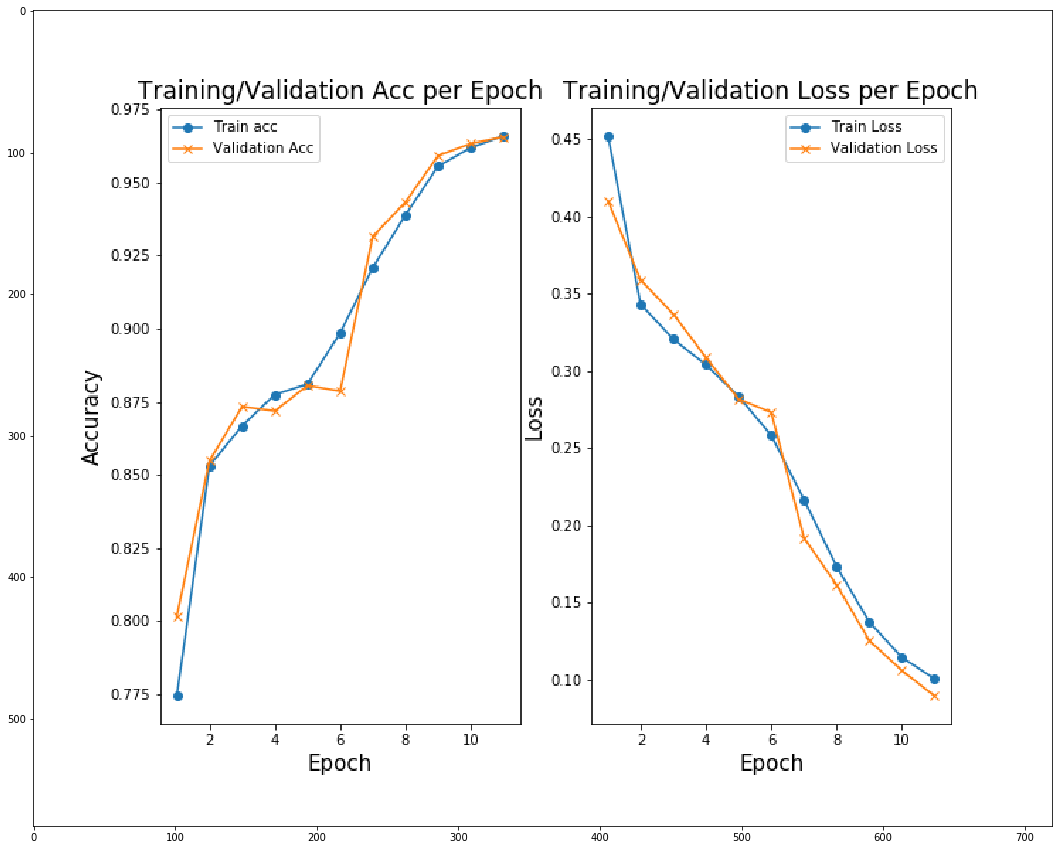

In [18]:
# recall this model's training
performance_isvc = plt.imread("LeNetPerformance-ISVC.png")
fig, ax = plt.subplots(figsize=(20,15))
ax.imshow(performance_isvc)

### Classifying 10% of generated data
With the loaded model, we now classify 10% of the available image slices (100 slices).
That is, we classify the image crops (both voids and fibers) from 100 slices.


In [19]:
# generating the 10% indexing
every_100th = np.arange(0,1000,10)

In [20]:
metrics_reg = []

# how long will this take?
time_start_reg = time.time()

for i in every_100th:
    fib_collection = io.ImageCollection(fiber_path + fiber_crops[i] + '/*.png',
                                       conserve_memory=True)
    void_collection = io.ImageCollection(void_path + void_spaces[i] + '/*.png',
                                        conserve_memory=True)   
    classify_them = predict_natalies(fib_collection, void_collection,model)
    metrics_reg.append(classify_them)
    
time_end_reg = time.time()
print("Classifying 10% of the image stack took", time_end_reg - time_start_reg, "seconds.")

Classifying 10% of the image stack took 7022.048803091049 seconds.


**Create data frame + graphs depicting results**

In [21]:
# results for non-augmented classification (10%)
df_reg = metrics_dataframe(metrics_reg)
df_reg.to_csv('metrics-reg-10.csv')

In [22]:
# show the mean
df_reg.mean(axis=0)

Sensitivity              0.920944
Specificity              0.965915
Precision                0.978832
Neg. Pred Rate           0.876699
False Pos. Rate          0.034085
False Neg. Rate          0.079056
False Discovery Rate:    0.021168
Accuracy                 0.937504
dtype: float64

### Classifying 10% of the augmented data
Rotated at 90 degrees.

In [23]:
# we will use the same indexes

metrics_rot = []

# how long will this take?
time_start_rot = time.time()

for j in every_100th:
    fib_90 = io.ImageCollection(fiber_path + fiber_crops[j] + '/*.png',
                               conserve_memory=True)
    void_90 = io.ImageCollection(void_path + void_spaces[j] + '/*.png',
                                conserve_memory = True)
    # we rotate images at 90 deg
    predict = predict_natalies(fib_90, void_90, model, rotate=True)
    metrics_rot.append(predict)
time_end_rot = time.time()
print("Classifying 10% of augmented data took ", time_end_rot - time_start_rot, " secs")    

Classifying 10% of augmented data took  9160.319326877594  secs


**Create dataframe to see classification results**

In [24]:
df_rotated = metrics_dataframe(metrics_rot)
df_rotated.to_csv('metrics-rotated-10.csv')

In [25]:
# show the mean again
df_rotated.mean(axis=0)

Sensitivity              0.976716
Specificity              0.911657
Precision                0.949834
Neg. Pred Rate           0.957969
False Pos. Rate          0.088343
False Neg. Rate          0.023284
False Discovery Rate:    0.050166
Accuracy                 0.952727
dtype: float64

## Create your own image crops!
Up until now, you have seen the reproduction of our experiments.
We now give you the opportunity to generate your own image crops, and retrain our CNN model.

Note that the image generation will be coming from other available stacks.
We will again keep this at 10% to save you a great deal of time.

1. Below you will find paths to the available stacks (besides the one we've created for you).
2. After your selection you may proceed to run the cells to generate crops from the selected stack.
3. All images are stored in the given file. Our default is " . ", you can change that if you want to.
4. Now you can classify all generated images with our trained model! 

In [26]:
path_seg = "data/seg_stacks/"
path_raw = "data/raw_stacks/"

**The segmented stack corresponding to the raw stack belongs share the same name.**

In [27]:
# these are the stack lists
seg_test = sorted([f for f in os.listdir(path_seg) if not f.startswith('.')])
raw_test = sorted([f for f in os.listdir(path_raw) if not f.startswith('.')])

**Your stack options:**
1. first number corresponds to the segmented stack
2. second number corresponds to its raw stack

e.g. a1 (segmented results of first available stack), a2 (raw microCT data of first available stack).

In [28]:
# indexing list
a1 = seg_test[0]
a2 = raw_test[0]
b1 = None
b2 = None
c1 = None
c2 = None

In [29]:
my_seg_stack = a1
my_raw_stack = a2

Importing all available cross sections in the selected stack

In [30]:
raw = io.ImageCollection(path_raw + my_raw_stack + '/*.tiff', conserve_memory=True)
seg = io.ImageCollection(path_seg + my_seg_stack + '/*.tif', conserve_memory=True)

In [31]:
len(raw) == len(seg)

True

### Generating crops of void spaces
**Your inputted path should end with a '/'**

We make you default directory for either method of cropping:

1. "void_crops"
2. "fiber_crops"

**For file name purposes, we have a set of indexes here that will help with the storing of crops.**


In [32]:
# storing every 10th file
tenth_file = np.arange(159, 1159, 10)

In [33]:
# indexing on every 10th image slice (10%) of the stack.
ten_percent = np.arange(0,1000, 10)

*Note: this should be accessed in order given how ImageCollection gathers files.*

In [34]:
# main call to generate crops
make_fibers(seg, raw, 'fiber_crops', tenth_file, ten_percent)

'Done! Generating fiber crops took 1330.970468044281 secs'

In [35]:
make_voids(seg, raw, 'void_crops', tenth_file, ten_percent)

/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


'Done! Generating voids lasted 980.1557991504669 secs'

## Now classify them

In [36]:
new_fibpath = 'fiber_crops/'
new_voidpath = 'void_crops/'

In [37]:
fiber_crops2 = sort_files(os.listdir('fiber_crops/'))
void_crops2 = sort_files(os.listdir('void_crops/'))


In [38]:
self_generated = []

# how long will this take?
time_start_self = time.time()

for el in range(len(fiber_crops2)):
    fib_self = io.ImageCollection(new_fibpath + fiber_crops2[el] + '/*.png',
                                       conserve_memory=True)
    void_self = io.ImageCollection(new_voidpath + void_crops2[el] + '/*.png',
                                        conserve_memory=True)   
    classify_self = predict_natalies(fib_self, void_self,model)
    self_generated.append(classify_self)
    
time_end_self = time.time()
print("Classifying 10% of the image stack took", time_end_self - time_start_self, "seconds.")

Classifying 10% of the image stack took 8735.456924915314 seconds.


In [40]:
your_exp = metrics_dataframe(self_generated)
your_exp.mean(axis=0)

Sensitivity              0.868565
Specificity              0.965915
Precision                0.979507
Neg. Pred Rate           0.796005
False Pos. Rate          0.034085
False Neg. Rate          0.131435
False Discovery Rate:    0.020493
Accuracy                 0.902364
dtype: float64

In [ ]:
# save? run me
file_name = "INSERTNAME.csv"
your_exp.to_csv(file_name)